In [2]:
import numpy as np
import pandas as pd
import plotnine as gg

from CurlingDB import CurlingDB
from utils.PlotnineElements import PlotnineElements as pe, blank

In [25]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Things to get
## Plots
- Match summary, plot all of the frames for each end for the whole match
- Stone heatmap
    - Stone heatmap per tournament or per year
- Player accuracy vs number of shots

## Stats
- Player accuracy
- Player accuracy by year, tournament
- Shot type frequency
- Accuracy by shot type
- Shot type frequency by type of shot

## Create Database Connection

In [4]:
# db = CurlingDB()
db = CurlingDB(db_name='world_curling.db')

## Curling Dimensions

In [5]:
# All values in m
circles = [0.152, 0.610, 1.219, 1.829]
pixel_to_m = 0.007370759
ice_width = [-4.75/2, 4.75/2]
ice_length = [-2, 6.401]
stone_radius = 14.5

# Circle values
inc = np.pi / 16
circle_range_x = np.cos(np.arange(0, 2 * np.pi + inc, inc))
circle_range_y = np.sin(np.arange(0, 2 * np.pi + inc, inc))

# Some Plots

## Stone Position Testing

In [6]:
stone_position_cmd = """
SELECT x, y, colour
FROM Stone
"""
db.execute_query(stone_position_cmd)
all_stone_positions = pd.DataFrame(db.cursor.fetchall(), columns=['x', 'y', 'colour'])
all_stone_positions.head()

,x,y,colour
0,-0.556492,1.245658,yellow
1,1.241973,3.877019,red
2,-0.556492,1.253029,yellow
3,1.238288,3.891761,red
4,-0.287460,-0.493841,yellow


### Filter out the top n most common

In [7]:
top_offenders = all_stone_positions[['x', 'y']].value_counts()[:6]
top_x = top_offenders.index.get_level_values(0)
top_y = top_offenders.index.get_level_values(1)
limited_stones = all_stone_positions.loc[(all_stone_positions.apply(lambda c: c['x'] not in top_x, axis=1) & (all_stone_positions.apply(lambda c: c['y'] not in top_y, axis=1)))]

### Create heatmap

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_bin_2d : Removed 37 rows containing missing values.


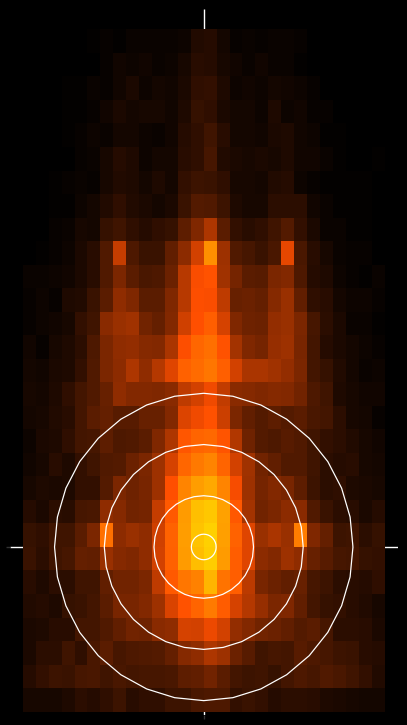

<ggplot: (692222717)>

In [8]:
size = 5
(gg.ggplot(limited_stones, gg.aes(x='x', y='y'))
     + gg.geom_bin_2d()
     + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y, colour='white')
     + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y, colour='white')
     + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y, colour='white')
     + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y, colour='white')

     + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
     + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
     # + gg.scale_fill_gradientn(colors=['#000000', '#ff4f00', '#E41C16'], values=[0, 0.3, 1], guide=False)
     + gg.scale_fill_gradientn(colors=['#000000', '#ff4f00', '#ffD000'], values=[0, 0.3, 1], guide=False)

     + gg.theme(text=gg.element_text(colour='#ffffff'))
     + gg.theme(axis_text=blank)
     + gg.theme(axis_title=blank)
     + gg.theme(figure_size=(size, size*((800 + 300)/(600))))

     + pe.background_colour(colour='black', plot_colour='black')
     + pe.remove_ticks(minor=True)
     )

## Match Summary
- TODO: Could introduce another query to get match specific, end specific, and frame/throw specific information
    - Include accuracy per team per end
    - Include type of throw per frame
    - Include player
    - Include current score


In [14]:
match_summary_cmd = """
SELECT m.team_1, m.team_2, e.num, e.hammer_colour, e.direction, p.frame_num, s.x, s.y, s.colour
FROM Stone s
RIGHT JOIN Position p
ON s.position_id = p.position_id
JOIN End e
ON p.end_id = e.end_id
JOIN Match m
ON e.match_id = m.match_id
WHERE m.match_id = ?
"""
db.execute_query(match_summary_cmd, (485,))
match_summary = pd.DataFrame(db.cursor.fetchall(), columns=['team_1', 'team_2', 'end_num', 'hammer_colour', 'play_direction', 'frame_num', 'x', 'y', 'colour'])
print(match_summary.shape)
match_summary.head()

(434, 9)


,team_1,team_2,end_num,hammer_colour,play_direction,frame_num,x,y,colour
0,OAR,NOR,1,yellow,down,0,0.003685,3.324212,red
1,OAR,NOR,1,yellow,down,0,0.003685,-0.464358,yellow
2,OAR,NOR,1,yellow,down,1,-0.103191,0.398021,red
3,OAR,NOR,1,yellow,down,1,0.007371,3.324212,red
4,OAR,NOR,1,yellow,down,1,0.007371,-0.464358,yellow


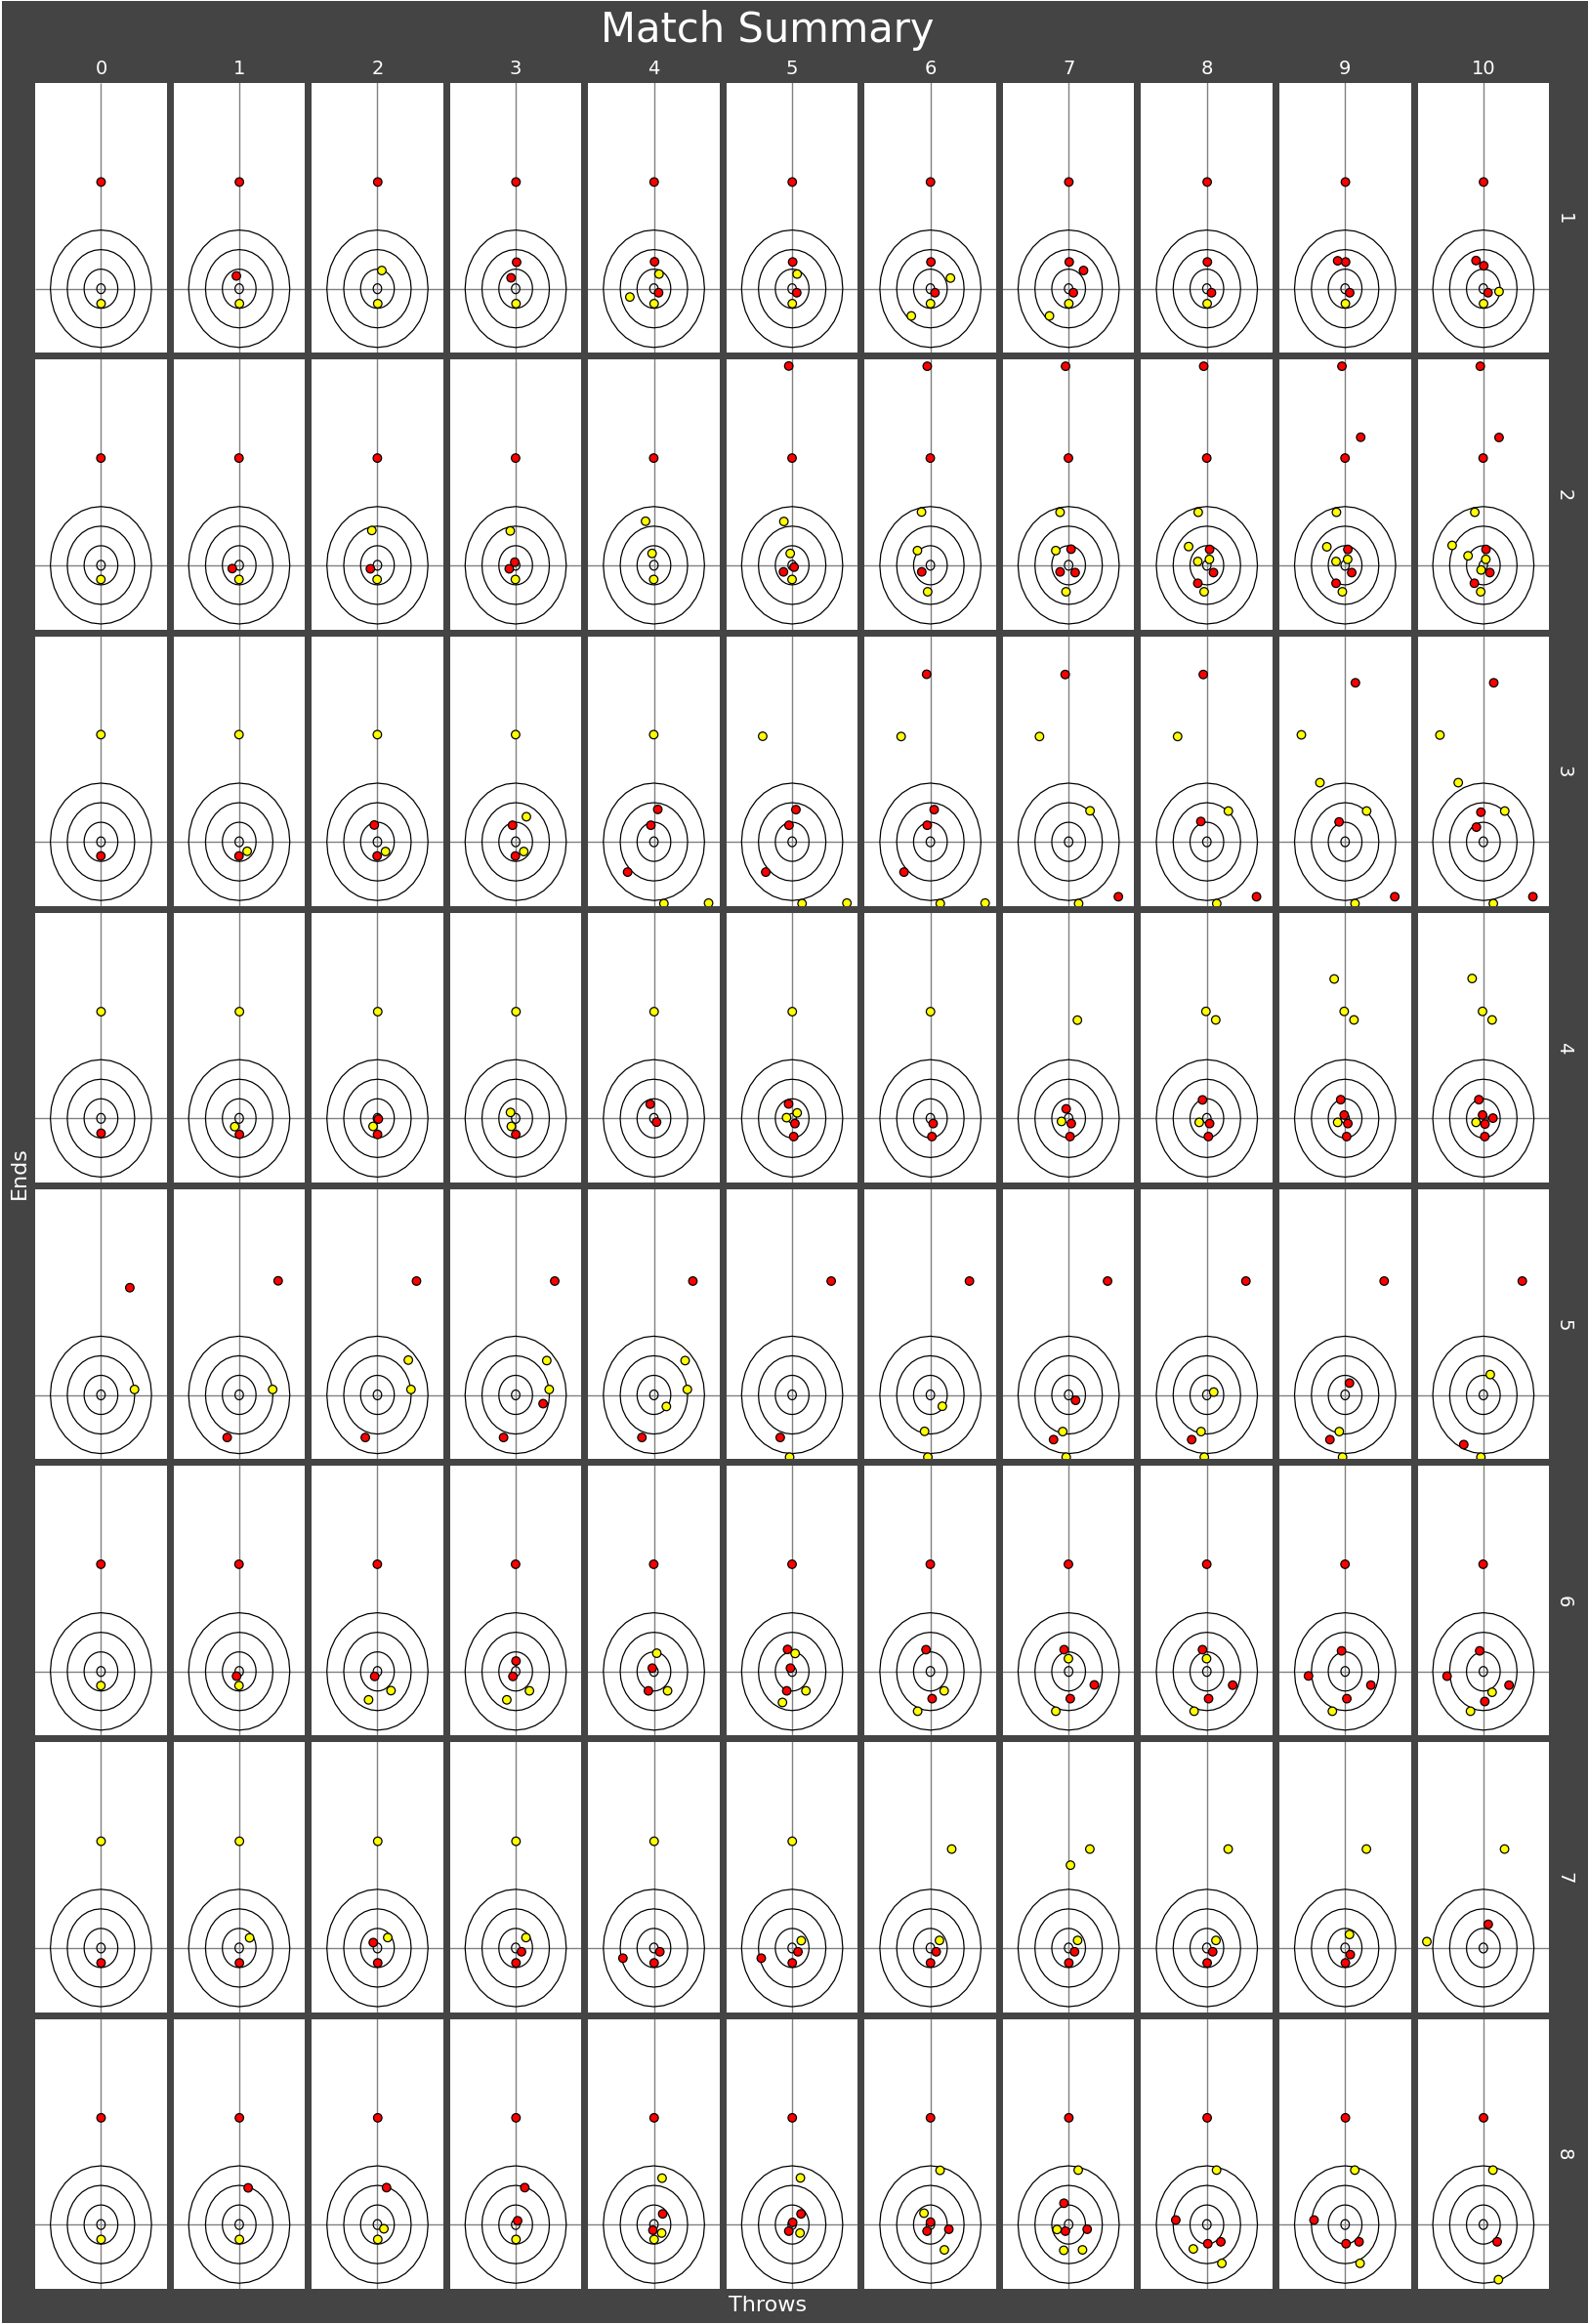

<ggplot: (709780544)>

In [16]:
size = 2
(gg.ggplot(match_summary, gg.aes(x='x', y='y', fill='colour'))
    + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y)
    + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y)
    + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y)
    + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y)
    + gg.geom_point(size=3)

    + gg.facet_grid('end_num ~ frame_num', space='free')

    + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_fill_manual(values=['red', 'yellow'], guide=False)
    + gg.theme(figure_size=(size * (match_summary['frame_num'].max()), size * (match_summary['end_num'].max()) * ((800 + 300)/(600))))
    + gg.theme(panel_grid=gg.element_line(colour='gray'))
    + gg.theme(text=gg.element_text(colour='white'))
    + gg.theme(axis_text=blank)
    + gg.theme(strip_text=gg.element_text(size=14), strip_background=blank)

    + pe.background_colour(panel_colour='#FFFFFF', plot_colour='#444444')
    + pe.remove_grid(minor=True)
    + pe.remove_ticks(minor=True, major=True)
    + pe.labels(title='Match Summary', x='Throws', y='Ends', title_size=30, x_size=16, y_size=16)
 )

## Linking Throws and Positions for Rating per Throw Type

In [58]:
# Get each throw along with the count of stones
linking_cmd = """
SELECT frames.position_id, frames.num, frames.frame_num, frames.coun, throws.colour, throws.name, throws.team, throws.type, throws.rating
FROM
(SELECT p.frame_num, 
        e1.num,
        p.position_id,
        e1.end_id,
        COUNT(*) as coun
FROM Stone s
JOIN Position p
  ON s.position_id = p.position_id
JOIN End e1
  ON p.end_id = e1.end_id
JOIN Match m1
  ON e1.match_id = m1.match_id
JOIN Event e2
  ON m1.event_id = e2.event_id
WHERE e2.event_id < ?
GROUP BY 3
) frames
LEFT JOIN
(SELECT t.throw_num, 
        t.colour, 
        p.name, 
        p.team, 
        t.type, 
        t.rating, 
        e1.num,
        e1.end_id
FROM Throw t
JOIN Player p
  ON t.player_id = p.player_id
JOIN End e1
  ON t.end_id = e1.end_id
JOIN Match m1
  ON e1.match_id = m1.match_id
JOIN Event e2
  ON m1.event_id = e2.event_id
WHERE e2.event_id < ?
) throws
  ON frames.frame_num = throws.throw_num AND frames.end_id = throws.end_id

"""
db.execute_query(linking_cmd, (3, 3))
# linking = pd.DataFrame(db.cursor.fetchall(), columns=['team_1', 'team_2', 'end_num', 'hammer_colour', 'play_direction', 'frame_num', 'rating', 'x', 'y', 'colour'])
linking = pd.DataFrame(db.cursor.fetchall(), columns=['position_id', 'end_num', 'throw_num', 'stone_count', 'colour', 'name', 'team', 'type', 'rating'])
print(linking.shape)
linking.head()

(13015, 9)


,position_id,end_num,throw_num,stone_count,colour,name,team,type,rating
0,2,1,1,1,yellow,FREDERICKS ARMSTR.,AUS,Draw,0.0
1,3,1,2,2,red,THOMPSON H,NZL,Front,2.0
2,4,1,3,3,yellow,FREDERICKS ARMSTR.,AUS,Draw,3.0
3,5,1,4,3,red,THOMPSON H,NZL,Draw,4.0
4,6,1,5,5,yellow,POWELL A,AUS,Take-out,2.0


In [59]:
linking.sort_values('stone_count', ascending=False).head(20)

,position_id,end_num,throw_num,stone_count,colour,name,team,type,rating
6932,7377,1,16,16,red,WANG B,CHN,Draw,4.0
6931,7376,1,15,15,yellow,JENTSCH D,GER,Draw,2.0
6930,7375,1,14,14,red,WANG B,CHN,Double Take-out,2.0
4783,5091,2,16,14,red,HOMAN R,CAN,Draw,0.0
7732,8228,2,16,14,red,HOMAN R,CAN,Draw,0.0
31,34,2,16,13,yellow,BECKER B,NZL,Draw,0.0
3620,3854,1,15,13,red,PAETZ A,SUI,Take-out,4.0
30,33,2,15,13,red,WILLIAMS H,AUS,Raise,2.0
1816,1934,9,16,13,red,KIM E,KOR,Draw,0.0
12278,13063,2,13,13,yellow,HOMAN R,CAN,Take-out,4.0


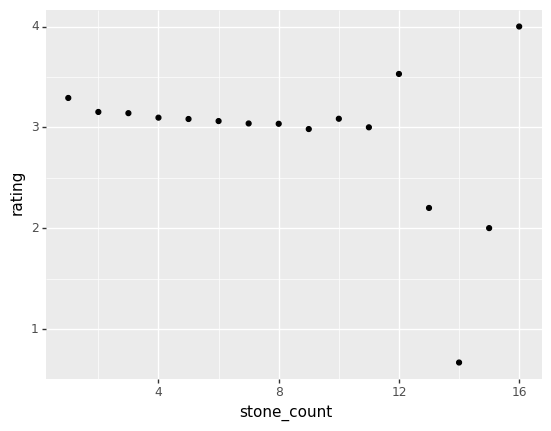

<ggplot: (704695574)>

In [60]:
gg.ggplot(linking.query('rating != -1').groupby(['stone_count']).agg({'rating': 'mean'}).reset_index(), gg.aes(x='stone_count', y='rating')) + gg.geom_point()

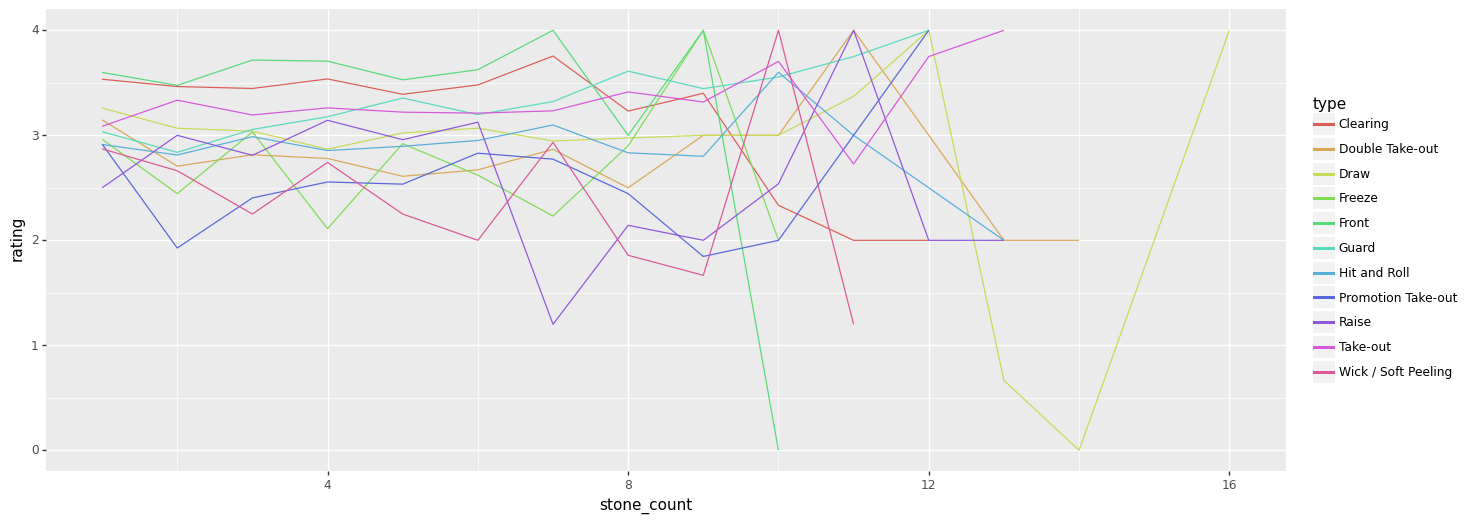

<ggplot: (694278407)>

In [61]:
gg.ggplot(linking.query('rating != -1').groupby(['type', 'stone_count']).agg({'rating': 'mean'}).reset_index(), gg.aes(x='stone_count', y='rating', colour='type')) + gg.geom_line() + gg.theme(figure_size=(16, 6))

## Player Accuracy

In [206]:
player_cmd = """
SELECT p.name, p.team, p.sex, t.throw_num, t.rating
FROM Throw t
JOIN Player p
  ON t.player_id = p.player_id
"""
db.execute_query(player_cmd)
players = pd.DataFrame(db.cursor.fetchall(), columns=['name', 'team', 'sex', 'throw_num', 'rating'])
print(players.shape)
players.head()

(255097, 5)


,name,team,sex,throw_num,rating
0,FREDERICKS ARMSTR.,AUS,f,1,0.0
1,THOMPSON H,NZL,f,2,2.0
2,FREDERICKS ARMSTR.,AUS,f,3,3.0
3,THOMPSON H,NZL,f,4,4.0
4,POWELL A,AUS,f,5,2.0


In [207]:
player_ratings = players.groupby(['name', 'team']).agg({'rating':['mean', 'count']})
player_ratings.columns = ['_'.join(col).strip() for col in player_ratings.columns.values]
player_ratings.dropna()

rating_mean  rating_count
name       team                           
ABBES E    GER      2.971306           697
ABE S      JPN      3.350932           322
ADAMS V    GBR      3.138889           216
           SCO      3.283019           742
ADVIENTO E NZL      2.141509           106
...                      ...           ...
ZHOU Y     CHN      3.131783           516
ZHUZBAY A  KAZ      2.686316           475
ZIOLO T    POL      2.000000            14
ZOU D      CHN      3.000000           431
ZOU Q      CHN      3.244866           633

[962 rows x 2 columns]

In [208]:
player_ratings.sort_values(by=('rating', 'count'), ascending=False).head(20)

KeyError: ('rating', 'count')

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 20 rows containing missing values.


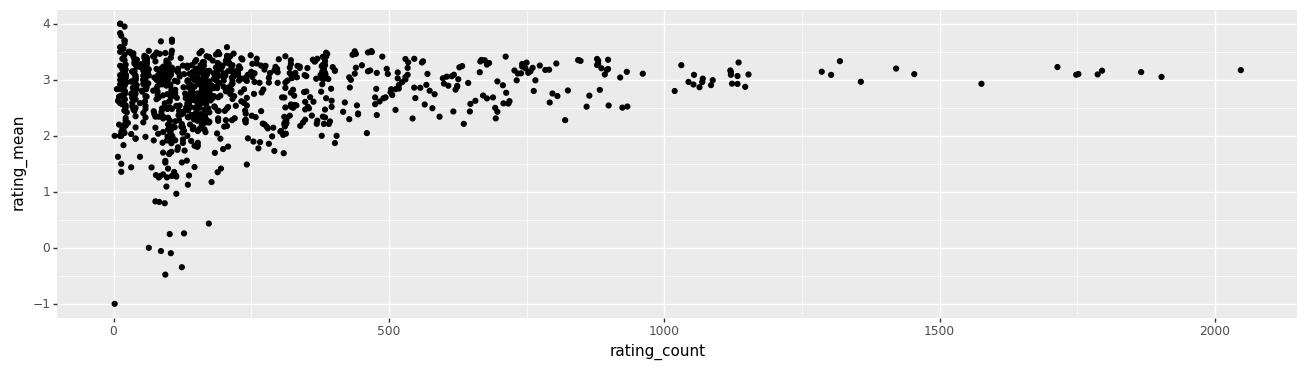

<ggplot: (732105304)>

In [ ]:
gg.ggplot(player_ratings, gg.aes(x='rating_count', y='rating_mean')) + gg.geom_point() + gg.theme(figure_size=(16, 4))